In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
% matplotlib inline

In [6]:
import pandas as pd
import numpy as np
import preprocessor as p
import re as regex
import re,string
import emoji

from nltk.stem.porter import *
stemmer = PorterStemmer()

census = pd.read_csv('ACS_10_5YR_S1902_with_ann.csv', sep=',', error_bad_lines=False, index_col=False, dtype='unicode', encoding='latin-1')
tweets = pd.read_csv('tweets.csv')


def strip_all_entities(text):
    entity_prefixes = ['@', '#', '_']
    text = text.replace('</br>', ' ')
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    text = text.replace('RT', '')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)


def remove_by_regex(t, regexp):
    t.replace(regexp, "", inplace=True)
    return t

def clean(tweets):
    tweets['text'] = tweets['text'].apply(lambda x: p.clean(x))
    return tweets

def remove_special_chars(t):  # it unrolls the hashtags to normal words
    special_chars = [",", ":", "\"", "=", "&", ";", "%", "$",
                     "@", "%", "^", "*", "(", ")", "{", "}",
                     "[", "]", "|", "/", "\\", ">", "<", "-",
                     "!", "?", ".", "'",
                     "--", "---", "#"]
    special_chars = [",", "\"", "=", "&", ";", "%", "$",
                     "@", "%", "^", "*", "{", "}",
                     "[", "]", "|", "\\", ">", "<", "-",
                      ".", "'",
                     "--", "---", "#"]
    special_chars = ["!", "?", "@", "."]
    for remove in map(lambda r: regex.compile(regex.escape(r)), special_chars):
        t.replace(remove, "", inplace=True)
    return t

def remove_usernames(t):
    return remove_by_regex(t, regex.compile(r"@[^\s]+[\s]?"))

def remove_numbers(t):
    return remove_by_regex(t, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

def remove_emojis(string):
    return ' '.join(c for c in string if c not in emoji.UNICODE_EMOJI)

def clean_tweets(t):
    t = t.dropna(subset=['text'])
   # t['text'] = pd.Series([row.decode('utf-8').encode('ascii', errors='ignore') for row in t['text']])
   # t['text'] = pd.Series([remove_emojis(row) for row in t['text']])
    t['text'] = remove_numbers(t['text'])
    t['text'] = t['text'].apply(strip_all_entities)
    t['text'] = remove_special_chars(t['text'])
    t['text'] = remove_usernames(t['text'])
    t['text'] = [removeNonAscii(row) for row in t['text']]

    return t

def removeNonAscii(s): 
    return ''.join(i for i in s if ord(i)<128)

def clean_txt(t): 
    t = pd.Series([strip_all_entities(row).lower() for row in t])
    t = remove_special_chars(t)
    t = remove_numbers(t)

    #t = [row.decode('utf-8').encode('ascii', errors='ignore') for row in t]
    t = [removeNonAscii(row) for row in t]
    return t

In [3]:
def get_bow(data):
    vectorizer = CountVectorizer(min_df=.005, max_df=.95, stop_words='english')
    X = vectorizer.fit_transform(data) 
    print(len(vectorizer.get_feature_names()))
    words = vectorizer.get_feature_names()
    return X, words

# Twitter Data

## split by NY borough

In [47]:
counties = pd.read_csv('tweets.csv').groupby('user_id').agg({'tweet': lambda x: ' '.join(x), 'county': 'first'})
counts = counties.groupby(['county']).agg(['count']).reset_index()
def money_to_float(money_str):
    return float(money_str.replace("$","").replace(",",""))
county_income = pd.read_csv('county_income.csv').dropna()
county_income['median_household'] = county_income['median_household'].apply(money_to_float)
county_income = pd.DataFrame(county_income.groupby('county')['median_household'].mean().reset_index())
df = pd.merge(counts, county_income, on ='county', how='left')
df.columns = ['county', 'county1', 'counts', 'income']
df.sort_values(by='counts')

In [89]:
tweets = pd.read_csv('tweets.csv')[['user_id', 'tweet', 'county']]
tweets = tweets[tweets['county'].isin(['New York', 'Queens', 'Bronx'])]
tweets = tweets.groupby('user_id').agg({'tweet': lambda x: ' '.join(x), 'county': lambda x:x.value_counts().index[0]})
tweets['text'] = tweets['tweet']

In [95]:
cleaned_tweets_NY = clean_tweets(tweets[tweets['county']=='New York'])['text']
cleaned_tweets_Bronx = clean_tweets(tweets[tweets['county']=='Bronx'])['text']
cleaned_tweets_Queens = clean_tweets(tweets[tweets['county']=='Queens'])['text']

In [97]:
X_NY, tweet_words_NY = get_bow(cleaned_tweets_NY)
X_Bronx, tweet_words_Bronx = get_bow(cleaned_tweets_Bronx)
X_Queens, tweet_words_Queens = get_bow(cleaned_tweets_Queens)

2686
3599
3597


In [98]:
NY_word_counts = X_NY.toarray().sum(axis=0)
Bronx_word_counts = X_Bronx.toarray().sum(axis=0)
Queens_word_counts = X_Queens.toarray().sum(axis=0)

ny 4.29465496656
bronx 4.35176843392
queens 4.29264001964


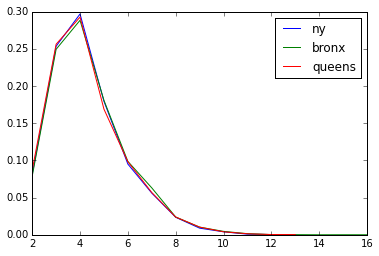

In [102]:
words = [tweet_words_NY, tweet_words_Bronx, tweet_words_Queens]
counts = [NY_word_counts, Bronx_word_counts, Queens_word_counts]
plot_word_length_freqencies(words, counts, ['ny', 'bronx', 'queens'])

In [105]:
all_ny = ' '.join([t for t in cleaned_tweets_NY])
all_bronx = ' '.join([t for t in cleaned_tweets_Bronx])
all_queens = ' '.join([t for t in cleaned_tweets_Queens])

In [119]:
cleaned_tweets = clean_tweets(tweets)
counties = np.array(cleaned_tweets['county'])

In [117]:
X, tweet_words = get_bow(cleaned_tweets['text'])


3021


In [145]:
word_counts_queens = np.sum(X[np.where(counties=='Queens')].toarray(), axis=0)
word_counts_bronx = np.sum(X[np.where(counties=='Bronx')].toarray(), axis=0)
word_counts_ny = np.sum(X[np.where(counties=='New York')].toarray(), axis=0)

total_counts = np.add(np.add(word_counts_bronx, word_counts_queens), word_counts_ny)

for doc in [word_counts_bronx, word_counts_ny, word_counts_queens]:
    doc_total = np.sum([doc])*1.0
    tf = np.array([count/total for count in doc])
    idf = np.array([np.log(1.0/t) for t in total_counts])
    tfidf = np.multiply(tf, idf)
    feats = tfidf.argsort()[-20:][::-1]
    print np.array(tweet_words)[feats]

[u'damnnnn' u'qnz' u'hoping' u'southside' u'wendys' u'lightskin' u'sweater'
 u'foul' u'dang' u'hasn' u'mam' u'cheating' u'dozo' u'mangoville'
 u'ignorance' u'idiot' u'alrite' u'timee' u'holdin' u'settle']
[u'knoww' u'buhh' u'buss' u'dozo' u'stare' u'bully' u'print' u'details'
 u'lookn' u'ohhhhh' u'hmmmmm' u'southside' u'petty' u'swagg' u'sheets'
 u'boredd' u'tommorow' u'sha' u'windows' u'icecream']
[u'ego' u'connect' u'paris' u'watchinq' u'hoy' u'louis' u'june'
 u'earthquake' u'common' u'ideas' u'yayyy' u'barely' u'spots' u'eggs'
 u'players' u'pal' u'breaks' u'reunion' u'students' u'stripper']


## Other stuff -- all tweets

In [356]:
tweets = pd.read_csv('tweets.csv')[['user_id', 'tweet']]

In [357]:
tweets = tweets.groupby('user_id').agg({'tweet': lambda x: ' '.join(x)})
tweets['text'] = tweets['tweet']


In [358]:
cleaned_tweets = clean_tweets(tweets)['text']

In [359]:
len(cleaned_tweets)

9246

In [366]:
import textwrap

half_tweets = []
n = 1000
for tweet in cleaned_tweets: 
    lines = textwrap.wrap(tweet, n, break_long_words=False)
    half_tweets.extend([l for l in lines if len(l.split()) > 4])

In [368]:
len(half_tweets)

23210

In [158]:
X, tweet_words = get_bow(cleaned_tweets)

4056


In [159]:
word_counts = X.toarray().sum(axis=0)
sorted_word_counts = sorted(X.toarray().sum(axis=0))
sorted_word_counts.reverse()
tweet_word_counts = word_counts

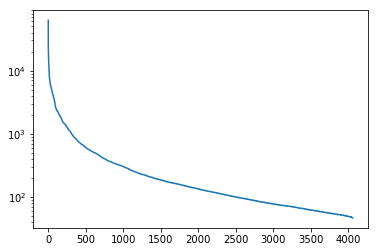

In [160]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.plot(range(len(sorted_word_counts)), sorted_word_counts)
plt.yscale('log')

# NEWS ARTICLES

In [161]:
news = pd.read_csv('Full-Economic-News-DFE-839861.csv')

In [280]:
split_news = news['text'].apply(lambda x: x.split('. ', 1))
news_sentences =[]
for x in split_news:
    news_sentences.extend(x)

In [281]:
clean_news = clean_txt(news['text'])

In [301]:
import textwrap

news_sentences = []
n = 140
for article in clean_news: 
    lines = textwrap.wrap(article, n, break_long_words=False)
    news_sentences.extend([l for l in lines if len(l.split()) > 4])

In [302]:
news_sentences

['new york yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week',
 'reflecting the overall decline in short term interest rates on small denomination or consumer cds sold directly by banks the average yield',
 'on six month deposits fell to from in the week ended yesterday according to an bank survey by banxquote money markets a wilmington del',
 'information service on three month consumer deposits the average yield sank to from the week before according to banxquote two banks in the',
 'banxquote survey citibank in new york and corestates in pennsylvania are paying less than on threemonth small denomination cds declines were',
 'somewhat smaller on five year consumer cds which eased to from banxquote said yields on three month and six month treasury bills sold at',
 'monday s auction plummeted more than a fifth of a percentage point from the previous week to and respectively',
 'the wall street journal online

In [165]:
X, news_words = get_bow(clean_news)

3051


In [166]:
word_counts = X.toarray().sum(axis=0)
sorted_word_counts = sorted(X.toarray().sum(axis=0))
sorted_word_counts.reverse()
news_word_counts = word_counts

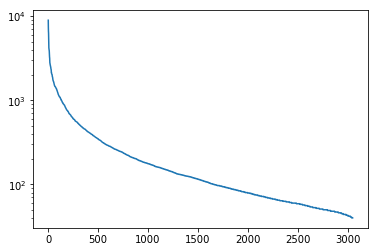

In [167]:
plt.plot(range(len(sorted_word_counts)), sorted_word_counts)
plt.yscale('log')

# Amazon Reviews

In [168]:
import json

def get_pandas_from_json(file): 
    df = pd.read_json(file, lines=True)
    return df

In [169]:
path = 'reviews_Electronics_5.json'
df = get_pandas_from_json(path)
#df = df.loc[df['overall'].isin([1,5])] 

#df = pd.read_csv('sample.csv')

In [170]:
sample = df.sample(17500)['reviewText']

In [171]:
clean_reviews = clean_txt(sample)

In [308]:
review_sentences = []
n = 140
for review in clean_reviews: 
    lines = textwrap.wrap(review, n, break_long_words=False)
    review_sentences.extend([l for l in lines if len(l.split()) > 4])

In [172]:
X, review_words = get_bow(clean_reviews)

1537


In [173]:
word_counts = X.toarray().sum(axis=0)
sorted_word_counts = sorted(X.toarray().sum(axis=0))
sorted_word_counts.reverse()
review_word_counts = word_counts

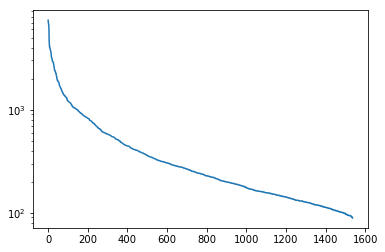

In [174]:
plt.plot(range(len(sorted_word_counts)), sorted_word_counts)
plt.yscale('log')

# MOVIE reviews

In [175]:
from os import listdir
from os.path import isfile, join


In [176]:
review_list = []
for basepath in ['aclImdb/train/pos/', 'aclImdb/train/neg/']:
    files = listdir(basepath)
    for fname in files:
        f = open(basepath + fname, 'r')
        text = ' '.join(f.readlines())
        review_list.append(text)

In [177]:
review_list_series = pd.Series(review_list)

In [178]:
sample = review_list_series.sample(17500)

In [179]:
clean_movie_reviews = clean_txt(sample)

In [316]:
movie_sentences = []
n = 140
for review in clean_movie_reviews: 
    lines = textwrap.wrap(review, n, break_long_words=False)
    movie_sentences.extend([l for l in lines if len(l.split()) > 4])

In [180]:
X, movie_review_words = get_bow(clean_movie_reviews)

2921


In [181]:
word_counts = X.toarray().sum(axis=0)
sorted_word_counts = sorted(X.toarray().sum(axis=0))
sorted_word_counts.reverse()
movie_review_counts = word_counts

## word lengths

In [244]:
from scipy.interpolate import spline

tableau20 = [(31, 119, 180),  (255, 127, 14),  
             (44, 160, 44),  (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    
  
  
def plot_word_length_freqencies(wordlists, countlists, labels):
    #common_words = list(set.intersection(*[set(w) for w in wordlists]))
    #common_words = list(set(tweet_words).intersection(set(news_words)))
    #sorted_common_words = sorted(common_words , key = len)
    #print "# words in common: ", len(common_words)
    i=0
    
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_color('grey')  
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_color('grey')   
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()
    plt.xlabel('length of word', color='grey', fontsize=16)
    plt.ylabel('% of words in dataset', color='grey', fontsize=16)

    for words, counts in zip(wordlists, countlists): 
        #common_counts = [counts[words.index(w)] for w in sorted_common_words]

        len_counts = {}
        for a,b in zip(words, counts):
            len_counts[len(a)] = len_counts.get(len(a), 0) + b
       
        total_words = sum(len_counts.values())
        
        weighted_sum = 0
        for length in len_counts.keys(): 
            weighted_sum += length*len_counts[length]
        weighted_avg = weighted_sum*1.0/total_words
        print labels[i], weighted_avg
        
        x = np.array(len_counts.keys())
        y = [val*100.0/total_words for val in len_counts.values()]
        
        xnew = np.linspace(x.min(),x.max(),300) #300 represents number of points to make between T.min and T.max
        power_smooth = spline(x,y,xnew)


        plt.plot(xnew, power_smooth, label=labels[i], color=tableau20[i])
        plt.axvline(x=weighted_avg, color=tableau20[i], linestyle=':', alpha=0.5)

        i += 1
    plt.legend(frameon=False, loc=(.65,0.1), fontsize=14)


tweets 4.40589234347
news 6.30880862706
amazon review 5.47301355491
movie reviews 5.43880321429


/Users/harini/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


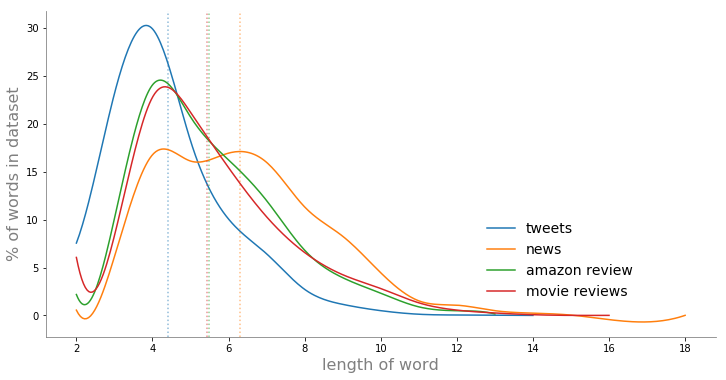

In [245]:
plot_word_length_freqencies([tweet_words, news_words, review_words, movie_review_words], [tweet_word_counts, news_word_counts, review_word_counts, movie_review_counts], ['tweets', 'news', 'amazon review', 'movie reviews'])

In [33]:
wordlists = [tweet_words, news_words, movie_review_words]
common_words = list(set.intersection(*[set(w) for w in wordlists]))
union_words = list(set.union(*[set(w) for w in wordlists]))

In [35]:
len(union_words)

6754

# Word Clouds

In [ ]:
eng

In [70]:
individual_tweets = pd.read_csv('tweets.csv')
individual_tweets['text'] = individual_tweets['tweet']
individual_tweets = clean_tweets(individual_tweets)['text'].sample(17500)

In [136]:
from PIL import Image
oval_mask = Image.open( "oval_mask.png")
oval_mask = oval_mask.convert("L") # convert image to black and white
oval_mask.mode = "L"
oval_mask = oval_mask.point(lambda x: 0 if x<128 else 255)
oval_mask = np.array(oval_mask)


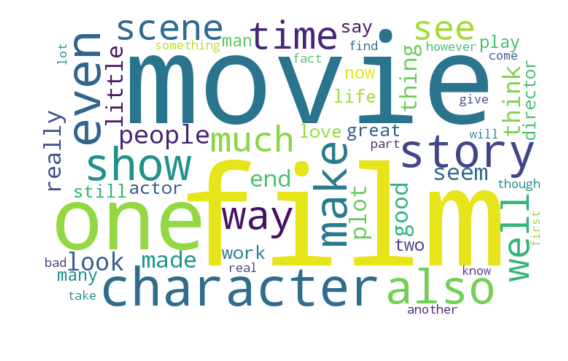

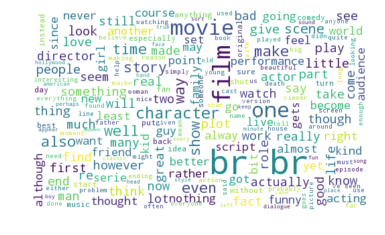

In [148]:
from os import path
from wordcloud import WordCloud, STOPWORDS

#d = path.dirname(__file__)

# Read the whole text.
text = ' '.join([t for t in clean_movie_reviews])
#text = open(path.join(d, 'constitution.txt')).read()

# Generate a word cloud image
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
wordcloud = WordCloud(background_color="white", mask=oval_mask, min_font_size=16, stopwords=stopwords).generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('news_wordcloud.png')

wordcloud = WordCloud(background_color="white", max_font_size=50, width=500, height=300).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Difficulty

In [36]:
import urllib2
from bs4 import BeautifulSoup
import pickle 

def get_difficulty(word):
    try: 
        wiki = 'http://www.dictionary.com/browse/' + word
        page = urllib2.urlopen(wiki)
        soup = BeautifulSoup(page)
        difficulty_box = soup.find('section', attrs={'id':'difficulty-box'})
        diff = int(difficulty_box['data-difficulty'])
        return diff

    except: 
        print 'did not find ' + word + ' in dictionary.com'


In [37]:
pickle_in = open("dict.pickle","rb")
difficulties = pickle.load(pickle_in)

In [38]:
len(difficulties)

6974

In [40]:
[u for u in union_words if u not in difficulties]

[u'gag',
 u'cardboard',
 u'intrigue',
 u'involvement',
 u'curiosity',
 u'helen',
 u'dragged',
 u'brilliance',
 u'enters',
 u'lacked',
 u'imagined',
 u'redemption',
 u'logical',
 u'elizabeth',
 u'meaningful',
 u'merit',
 u'menacing',
 u'pacino',
 u'sophisticated',
 u'persona',
 u'dragon',
 u'sitcom',
 u'idiots',
 u'admire',
 u'infamous',
 u'anime',
 u'jessica',
 u'corrupt',
 u'nancy',
 u'inspiring',
 u'appalling',
 u'rushed',
 u'pitt',
 u'sentimental',
 u'centered',
 u'flop',
 u'roy',
 u'realise',
 u'obsession',
 u'dramas',
 u'definite',
 u'mob',
 u'grows',
 u'colour',
 u'wilson',
 u'aired',
 u'translation',
 u'blair',
 u'psychotic',
 u'incoherent',
 u'kidnapped',
 u'dignity',
 u'struggles',
 u'worlds',
 u'horrors',
 u'plague',
 u'massacre']

In [41]:
for w in union_words: 
    if w not in difficulties: 
        difficulties[w] = get_difficulty(w)

/Users/harini/miniconda2/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /Users/harini/miniconda2/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


did not find pacino in dictionary.com


In [42]:
pickle_out = open("dict.pickle","wb")
pickle.dump(difficulties, pickle_out)
pickle_out.close()

In [43]:
def plot_difficulties(wordlists, countlists, labels, difficulty_dict):

    i=0
    for words, counts in zip(wordlists, countlists): 
        diff_counts = {}
        for word, count in zip(words, counts):
            if word in difficulty_dict and difficulty_dict[word]: 
                difficulty = difficulty_dict[word]
                diff_counts[difficulty] = diff_counts.get(difficulty, 0) + count
       
        total_words = sum(diff_counts.values())
        
        weighted_sum = 0
        for diff in diff_counts.keys(): 
            weighted_sum += diff*diff_counts[diff]
        weighted_avg = weighted_sum*1.0/total_words
        print labels[i], weighted_avg
        
        plt.plot(diff_counts.keys(), [val*1.0/total_words for val in diff_counts.values()], label=labels[i])
        i += 1
        
    plt.legend()


tweets 15.9404877146
news 13.4376396535
movie reviews 14.7338603335


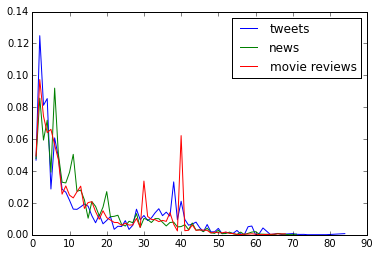

In [44]:
plot_difficulties([tweet_words, news_words, movie_review_words], [tweet_word_counts, news_word_counts, movie_review_counts], ['tweets', 'news', 'movie reviews'], difficulties)


# Classify as English

In [235]:
#language_tweets = get_pandas_from_json('/Users/harini/Desktop/hydrated4-1.json')

In [399]:
data = []
with open('/Users/harini/Desktop/hydrated4-1.json') as f:
    for line in f:
        data.append(json.loads(line))
data = np.array(data)     

In [400]:
language_tweets = pd.DataFrame({'id': data[:,0], 'text': data[:,1]})

In [401]:
labels = pd.read_csv('/Users/harini/Desktop/uniformly_sampled.tsv', sep='\t', header=None)

In [402]:
labels.columns = ['language', 'id']

In [403]:
language_tweets.columns = ['id', 'text']

In [404]:
language_tweets.id = language_tweets.id.astype('int64')

In [405]:
language_tweets = pd.merge(language_tweets, labels, on='id', how='left')

In [406]:
language_tweets.is_english = (language_tweets.language == 'en').astype('int64')

In [421]:
# x = clean_tweets(language_tweets)['text'].str.strip()[np.where(x != '')[0]]
# y = language_tweets.is_english[np.where(x != '')[0]]

x = language_tweets['text']
y = language_tweets.is_english

In [426]:
vectorizer = CountVectorizer(min_df=5, max_df=0.95, stop_words='english')
X = vectorizer.fit_transform(x) 
#print(X.toarray())
#print(vectorizer.get_feature_names())

In [427]:
tw = pd.read_csv('tweets.csv').sample(18000)
tw['text'] = tw.tweet
tw = clean_tweets(tw)['text']
X2 = vectorizer.transform(tw)

In [430]:
from scipy.sparse import vstack

X = vstack([X, X2])

In [435]:
y = np.concatenate((y, np.ones(len(X2.toarray()))))

In [436]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=0, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.125, random_state=0, stratify=y_train)

In [437]:
from sklearn.linear_model import LogisticRegression

lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
Cs = [1.0/l for l in lambdas]

val_scores = []
test_scores = []
for i in range(len(Cs)):
    lr = LogisticRegression(C=Cs[i])
    lr.fit(X_train, y_train)
    val_scores.append(lr.score(X_val, y_val))
    test_scores.append(lr.score(X_test, y_test))

best_C_idx = np.argmax(val_scores)
best_C = Cs[best_C_idx]
print lambdas[best_C_idx]
print test_scores[best_C_idx]

0.1
0.923512747875


In [438]:
1 - 0.923512747875

0.07648725212499996

In [424]:
X

<18000x7669 sparse matrix of type '<type 'numpy.int64'>'
	with 71742 stored elements in Compressed Sparse Row format>

In [425]:
lr = LogisticRegression(C=best_C)
lr.fit(X_train, y_train)
lr.score(X, np.ones(len(tw)))

0.83744444444444444

In [258]:
import langid
from langid.langid import LanguageIdentifier, model

In [259]:
english_tweets = language_tweets[language_tweets.language == 'en']

In [274]:
eng = english_tweets['text']

In [380]:
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
tweet_languages = dict()

tw = pd.read_csv('tweets.csv').sample(18000)
tw['text'] = tw['tweet']

for t in clean_tweets(tw)['text']: 
    res = identifier.classify(t)
    if res[0] not in tweet_languages:
        tweet_languages[res[0]] = list()
    if res[0] != 'en': print t, res[0]
    tweet_languages[res[0]] = tweet_languages[res[0]] + [res[1]]
    

Yu would wanna follow mii lil sis luv ha x sw
wait lol kno bout wat ur late ass responses fr
u goin mt
Mm iceberrryy de
Dear lord don t let me die tonight af
Harlem harlem harlem da
Come Clean Jeru da Damaja de
I m at followers I need some more no
goin in da shower de
my GORGEOUS ladies de
Oh how I love my kenya id
to a it
check ur dm fr
Feelin good n shit n de
Users djdeejay Desktop FRONT jpg nl
u got pressure mt
lt butt raping your timeline sv
FUqQ DHAT SHiiT i WANT A DONUT AND A COKiiE no
nope smh I m goin crrazy pl
shiiih leem kno I live ur playa shit id
Underwear shopping time nl
lmao Fuckin bum pt
Lmao If I hear another person say I look like Joe Budden maaaan nl
therz shit evrywer br
Whoa mii seh mii nah let go SHEE NAHH LET GOOO sw
nah im lying im stayin home slut de
dshanacarter skype me da
yayyyyyyy az
My hair smells so GOOD ga
haha esta archulife u U an
good girl nathan laying down id
she did it
Bumpiin fi
awww shut up pl
yeah buddy cs
whyy fi
say sumthnnn babyyy az
cuidao c

Yes sir ha ha you arab too br
LOL i knew it da
iloveyou ro
hey stranger Como estas eo
so u a rapper cs
na wut happened ms
Goodmorning Hiiii guuysss goodmorniing neek et
Lez get tatted eu
Goodnight i guess Ugh i feel a bad dream coming on cy
Applause Applause Applause lt
Lmao Niggas Are Late I Guess tl
LMAO dead DEEEEYYYYYYUUUUMMMMMMM BRUH es
lmfao Wat dey say do tell do tell Lol br
uh huh et
kyky look just like you kyky look jus like pop qu
disculpen q no les he podido enviar la cancin Tengo un pequeo problema con la compu es
oh ok lol Damn next time sv
feins ask for cent nn
wow deadass es
hehe de
big prob sis de
put ya flood warnings out id
Lataa fi
u kno it it
No more dr Pepper left it
Damn duke s zone smh eu
cool yo me arregle en la morning pero para ir a la tienda so i have to change haaha es
mmm Idkkk I Mite Be Deaa de
que es lo que se dice se los que maman gallo pa dnde es ke van jejeje es
ohz ok lol damn fr
get home safe nl
chillin work lookin vids hbu nl
why I gotta kum for u t

MY SON FABOLOUS MIXTAPE DROP AT WONDER IF IT GONNA BE BETTER DEN NO CEILINGS most def fr
I want ya sicko I want u bad I want ya bad romance sw
Big Poppa Notorious B I G sv
i hear u ha mt
myy sweetie pie lv
follow my G M B fam do or die bed stuy af
I M TRAPPIN IN DA PUSSY HAHAHAHAHA  hmmmm lol mt
is China your pet LOL I m lost es
nothin dear de
picture picture picture picture picture picture picture picture picture picture picture picture picture picture picture ro
lol Oh no You re sick it
lol I know hope u enjoy Ur trip hr
ohh noooo baby I aint mean to do dat pt
lmao werd aight de
steve miller band no
im ciomeing bac de
Vacuuming fi
Eres My Vida My Razon de Ser La Realizacion De un Sueo al k kiero ver en cada amanecer TE AMO para volar sin tiempo y sin espacio es
lmao y u lauffin an
Kayyyyy fi
ok good nl
SAT MAH JETSET PRESENTS A NITE CALLED WI LIFE SOON SO OUT OASIS LINDEN BLVD MUSIC BY JOE YOUNG JUNYA BAM fr
we comin for ya ll next sw
Bella sigues en la Peninsula es
lollsz hu
Good po

ya I get it sv
lol yu like em pt
Man I miss my sister so much sv
I m going home todayyy D fi
slips note size lol es
Stackin doin chorus fr
my set shit yuh de
Wit my bro jazz it
PPL PLEASE STOP GASSING RECORDS New Drake is OK gt gt gt EXACTLY nl
lmao owned pt
ummmm aiiight mt
REALLY cute love it ro
No nigga wanna play o I can play shut up tl
Track Neighbors kno my name pl
in bed hella sick it
hello sexy it
heyyyy fi
Damn bro Had let tearz drop Smh pl
lmaooo da shit i hear it
Lieing period de
lmaoo if uu sayy so fi
let my nigga go you bitches lmao tl
Bad girls club baby pl
lol i knw da
you good Text me mt
Bang bang get a gang tl
On d way berm nl
go church it
Fr gt gt you re a sucker lt lt da
Trey songz ONE LOVE fr
dontt ialwayss lOl sv
I d appreciate it it
lmaaaoo fi
i assume u like it mt
goodnight DONT LET THE BED BUGS BITE fr
Man drizzy Crazy pl
oh haha yeaaaaa xh
whatcha doin saturday ashleyyyyyy az
Dats Wassup Yuuup Lol nl
I ve lost my mojo es
Wow trey songzzzzzzzzzzzzzzz yup sounds 

yo yo es
hme now de
Tripple Rz ent Rugby Robins ReliqiOnszzzz hu
Twitta type dry it
IF YOURE READING THIS THEN FOLLOW MY GROUPS NEW TWITTER PLEASE pl
ghostdjgmail com it
lmao naughtyyy girl az
ummmm Lol mt
lmaaaaaao fi
if i say no dast fuckin time imma say no afuckingain pt
hell nahh Fck I look lyk Lls cy
hahaha YAY es
shyt juz mad sum movez nd shoopin wat u doin tomorrow br
EVERYBODY THIS FUCK MONTEYA JOHNSON He s Not A cs
naaa i cant my mouf dont stop yappin sw
wha mi say wrong mt
wat u wanna talk about mt
awwwwww I m a fat ass so pt
I m late but I went to morgan I m up bowie now pl
Gnite aqain cocoa puffs xh
Here I come Richmond va club aurora de
If all your teeth fell out cy
haha you p sw
lmao i can c dat shit happening but yea dat might b se
Kassav Zouk la se sel medikaman it
yea i kno sv
liike et
new word u like it af
mi bro s it
lmao right pt
fuuuuuuuuuuuuuuuucccccckkkkkkkkkk et
da G homie es
skinny jeans pl
ok ma am id
Dat nigga got meh shakin n shxt STiiLL tl
lol u had nightma

o iiiiight lol it
matematika selesai es
you watcht he hills bad girls club ect de
happy bday nigga sv
whaahh Guu fi
nerd de
lmao smh pt
Denyin ur feelings for me da
lmao You already et
Hungry de
blink blink blink blink no
GogglinG Listerine Will Not ii Repeat Will Not Clean Your Mouth Your Breath Still Gon Smell Like A Sack Of Shit sv
lol Superman Swag I can dig it nl
I m in Maywood Illinois it
you gettin implants tr
La ley de los videojuegos era absolutamente necesaria Ya dije mi falacia del da es
Los politicos que se la pasan en twitter los entiendo es facil no sudan no huelen carajito cagao ni viejita sin desod es
ole well fucker sv
oh I feel u Fuck em nl
Les regalo este proberbio romano que nos dice mucho Por la ignorancia nos equivocamos y por las equivocaciones aprendemos es
a knock out king wut u doin rw
HA p adores me es
I didn t bbm him lol de
get sum matchin uggs lmao de
imma look durinq sprinq break mt
Follow my girl gt gt gt lt lt lt follow my girl de
smh here u go mt
LET M

yo nigga sv
Imm extra bored es
Wen do u want me get on derre nl
y cre k tu cre soy malacorista No noooooo eo
All You Gotta Do Is Try sv
AND FUNNY THING IS YOU SAY YOU MY HOMIE BUT U TALKIN SHIT ITS ALL GOOD THO THEY TALKED BOUT JESUS SO WHO AM I mt
di docta n lady saw inna combination pull di fuck uppp it
I guess ur right amiga Did u get ur piercings lv
Baldwin Hills lt lt a rerun de
Damn da bass in dis car is sick And I m sittin in da back lt check u out check me out wat af
truuuu do ya thing bro sw
HAPPY BIHDAY HAVE FUN AND BE SAFE gt Thanks sweetie I appreciate it nl
Damn u fast mt
Can get it gt gt gt OH NO its U again lmao nl
yea u better lol mt
Mcdonalds w nd um no school pt
Kinda scared it
we donee Finito Finishheedd it
Damn Son u Keep chasin dat Chick Let Dat Bitch Breath an
no i didnt or did i lol it
el fin est cerca convirtase a su iglesia ms cercana es
diablo entonce el viaje es
happy birthday meanie lol wish you many more pl
Nobody wanna exercise di brain pure bullshit convo

IF YOU AREN T FOLLOWING THE THEN MAKE SURE YOU CLICK ON FOLLOW NOW GO FOLLOW pl
lmao u aint joking hr
Baq home mt
Good morning bebe de
Chikfila move sl
lol oh out da gate Def didn tget about dinner haha u kno I m fat lol gt I kno lol br
gt ite de
yuuuuuuuuuuup et
Aye jus get da towel since daddys home wa
Thanks Sue preciate it es
is dat a real question pt
subway sandwhiich yu alreadiii de
wats good fr
Oh yea Hi everyone on my timeline blah blah blah have a good day whatever id
hello handsome es
I aint worried nl
tu subes las fotos al revs es
them super dike girls ca
to rock USPA THINK you re hott shit No bueno baby it
oh ook kool et
more until i got followers da
My legs feel like jello LOL bs
Pause I miss u b via hr
digney da
yeaaa u alreadyy kno hr
yea cuz u ate starvin marvin lmao nl


In [370]:
sum([len(tweet_languages[lang]) for lang in tweet_languages.keys() if lang != 'en'])

278

In [371]:
len(half_tweets)

23210

In [372]:
278./23210.

0.011977595863851788

In [355]:
1884./18000.

0.10466666666666667

In [364]:
83./9246.

0.008976854856154013

In [444]:
tweets_with_location = pd.read_csv('tweets.csv')[['lat', 'lng', 'tweet']]

In [445]:
tweets_with_location = tweets_with_location.as_matrix()

In [446]:
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
tweet_languages = dict()
misclassified_lat_longs = []
for i in range(len(tweets_with_location)): 
    t = tweets_with_location[i][2]
    res = identifier.classify(t)
    if res[0] not in tweet_languages:
        tweet_languages[res[0]] = list()
    if res[0] != 'en': 
        #print t, res[0]
        misclassified_lat_longs.append([tweets_with_location[i][0], tweets_with_location[i][1]])
    if i % 500 == 0: print i 
    tweet_languages[res[0]] = tweet_languages[res[0]] + [res[1]]

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
8500

In [447]:
sum([len(tweet_languages[lang]) for lang in tweet_languages.keys() if lang != 'en'])

35778

In [7]:
misclassified_lat_longs = np.load('misclassified_lat_longs.csv.npy')

In [8]:
lat_longs = pd.DataFrame(misclassified_lat_longs)
lat_longs.columns = ['lat', 'long']
#lat_longs = lat_longs.round(2)
lat_long_counts = lat_longs.groupby(['lat', 'long']).size().reset_index()
lat_long_counts.columns = ['lat', 'long', 'count']

In [9]:
all_lat_longs = pd.read_csv('tweets.csv')[['lat', 'lng']]
#all_lat_longs = all_lat_longs.round(2)

all_lat_long_counts = all_lat_longs.groupby(['lat', 'lng']).size().reset_index()
all_lat_long_counts.columns = ['lat', 'long', 'all_count']

In [10]:
lat_long_counts = pd.merge(all_lat_long_counts, lat_long_counts, on=['lat', 'long'], how='left')


In [11]:
lat_long_counts = lat_long_counts.fillna(0)

In [12]:
lat_long_counts['percent_misclass'] = lat_long_counts['count']*1.0/lat_long_counts.all_count

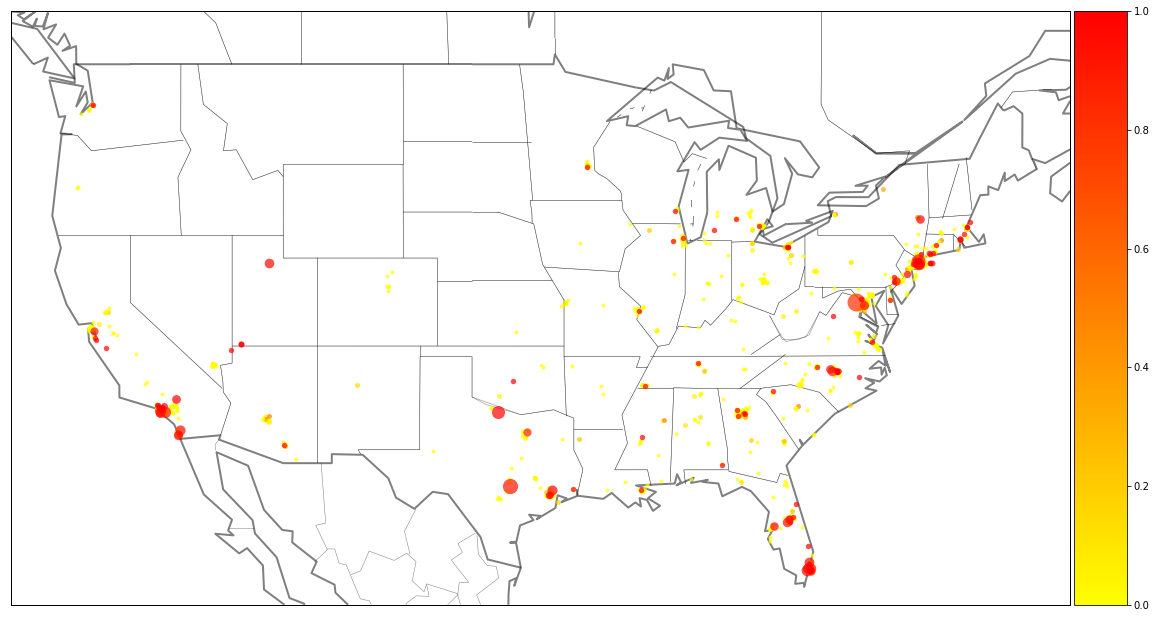

In [39]:
import matplotlib.pyplot as plt
import matplotlib.cm
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(20,30))


m = Basemap(resolution='c', # c, l, i, h, f or None
            projection='merc',
            lat_0=38., lon_0=95.,
            llcrnrlon=-127., llcrnrlat= 24, urcrnrlon=-65., urcrnrlat=51.)


m.drawmapboundary()
m.fillcontinents(color='white')
m.drawstates(color=(0,0,0,0.5))
m.drawcountries(color=(0,0,0,0.5), linewidth=2)
m.drawcoastlines(color=(0,0,0,0.5), linewidth=2)

def plot_area(pos):
    count = new_areas.loc[new_areas.pos == pos]['count']
    x, y = m(pos[1], pos[0])
    size = (count/1000) ** 2 + 3
    m.plot(x, y, 'o', markersize=size, color='#444444', alpha=0.8)
    

# max_count = max(lat_long_counts['count'].apply(np.log))*1.0
# for i in range(len(lat_long_counts)):
#     lat, lon = lat_long_counts.iloc[i]['lat'], lat_long_counts.iloc[i]['long']
#     x, y = m(lon, lat)
#     count = np.log(lat_long_counts.iloc[i]['count'])/max_count
#     m.plot(x, y, 'o', color='red', alpha=count)

# plt.figure()

#max_count = max(all_lat_long_counts['all_count'].apply(np.log))*1.0

cmap = plt.cm.autumn_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=1.0)

max_count = max(lat_long_counts['count'])
#lat_long_counts['count'] = lat_long_counts['count']*1.0/max_count

top_ll = lat_long_counts[(lat_long_counts['percent_misclass'] > 0.8) & (lat_long_counts['count'] > 1)]
bottom_ll = lat_long_counts[(lat_long_counts['percent_misclass'] <= 0.8) & (lat_long_counts['count'] <= 1)]
ll = pd.concat([bottom_ll.sample(1000), top_ll])

for i in range(len(ll)):
    lat, lon = ll.iloc[i]['lat'], ll.iloc[i]['long']
    x, y = m(lon, lat)
    count = ll.iloc[i]['percent_misclass']
    size = 4 + np.sqrt(ll.iloc[i]['count'])
    m.plot(x, y, 'o', markersize=size, color=cmap(norm(count)), alpha=0.7, markeredgewidth=0.0)
    
from mpl_toolkits.axes_grid1 import make_axes_locatable

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(sm, cax=cax)
#fig.colorbar(sm)

45052


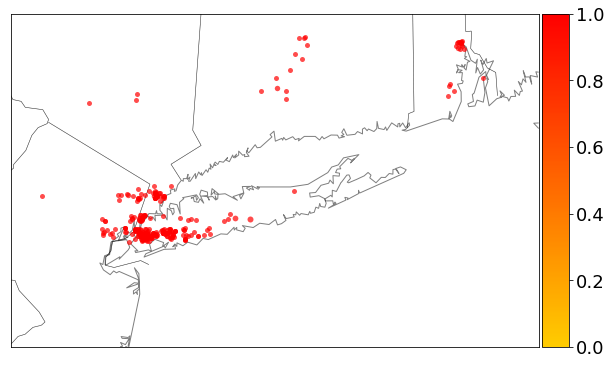

In [68]:
import matplotlib.pyplot as plt
import matplotlib.cm
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(10,7))


m = Basemap(resolution='i', # c, l, i, h, f or None
            projection='merc',
            lat_0=41, lon_0=-73.,
            llcrnrlon=-75., llcrnrlat= 40., urcrnrlon=-70.8, urcrnrlat=42.)


#m.drawmapboundary(color=(0,0,0,0.5))
m.fillcontinents(color='white')
m.drawstates(color=(0,0,0,0.5))
#m.drawcountries(color=(0,0,0,0.5))
m.drawcoastlines(color=(0,0,0,0.5))


def plot_area(pos):
    count = new_areas.loc[new_areas.pos == pos]['count']
    x, y = m(pos[1], pos[0])
    size = (count/1000) ** 2 + 3
    m.plot(x, y, 'o', markersize=size, color='#444444', alpha=0.8)
    

# max_count = max(lat_long_counts['count'].apply(np.log))*1.0
# for i in range(len(lat_long_counts)):
#     lat, lon = lat_long_counts.iloc[i]['lat'], lat_long_counts.iloc[i]['long']
#     x, y = m(lon, lat)
#     count = np.log(lat_long_counts.iloc[i]['count'])/max_count
#     m.plot(x, y, 'o', color='red', alpha=count)

# plt.figure()

#max_count = max(all_lat_long_counts['all_count'].apply(np.log))*1.0

cmap = plt.cm.autumn_r
cmap = plt.get_cmap('autumn_r')
cmap = truncate_colormap(cmap, 0.2, 1)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1.0)

max_count = max(lat_long_counts['count'])
#lat_long_counts['count'] = lat_long_counts['count']*1.0/max_count

ll = lat_long_counts[(lat_long_counts.lat > -.75)& (lat_long_counts.lat < -.71) & (lat_long_counts.long > 40.)&(lat_long_counts.long< 42.)]
ll = lat_long_counts.sort_values(by='percent_misclass')
print len(ll)

for i in range(len(ll))[-1000:]:
    lat, lon = ll.iloc[i]['lat'], ll.iloc[i]['long']
    x, y = m(lon, lat)
    count = ll.iloc[i]['percent_misclass']
    size = 4 + np.sqrt(ll.iloc[i]['count'])
    m.plot(x, y, 'o', markersize=size, color=cmap(norm(count)), alpha=0.7, markeredgewidth=0.0)
    
from mpl_toolkits.axes_grid1 import make_axes_locatable

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(sm, cax=cax)
#fig.colorbar(sm)
cbar.ax.tick_params(labelsize=18)

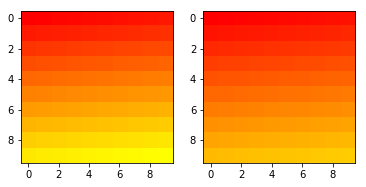

In [54]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
cmap(np.linspace(0.2, 0.8, 100))

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('autumn')
new_cmap = truncate_colormap(cmap, 0, .8)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

In [321]:
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
news_languages = dict()
for t in clean_news: 
    res = identifier.classify(t)
    if res[0] not in news_languages:
        news_languages[res[0]] = list()
    if res[0] != 'en': print t, res[0]
    news_languages[res[0]] = news_languages[res[0]] + [res[1]]

 n n n n n n n n n n n n n n n n n n n n n mai date mav n may n jun n n n n n n n n n n n n fgn currency dollar in in dollars fgn currency wed tue wed tue argentina japan dav dav dav jordan kuwait lebanon mexico new zealnd norway vperu philippines portugal saudi arab singapore so africa spain sweden switzerlnd dav fut dav ful dav tut turkey uruguay venezuela w gcrmnv dav tut dav fut dav ful br


In [322]:
sum([len(news_languages[lang]) for lang in news_languages.keys() if lang != 'en'])

1

In [335]:
(sum([len(news_languages[lang]) for lang in news_languages.keys() if lang != 'en']))/(len(clean_news))

0

In [307]:
len(news_sentences)

77684

In [418]:
total = sum([len(news_languages[lang]) for lang in news_languages.keys()])
[len(news_languages[lang])*1.0/total for lang in news_languages.keys()]

[6.25e-05, 0.9995625, 0.000125, 6.25e-05, 6.25e-05, 6.25e-05, 6.25e-05]

In [325]:
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
review_languages = dict()
for t in clean_reviews: 
    res = identifier.classify(t)
    if res[0] not in review_languages:
        review_languages[res[0]] = list()
    if res[0] != 'en': print t, res[0]
    review_languages[res[0]] = review_languages[res[0]] + [res[1]]

it use ok fr
lleg oacute en el tiempo establecido por el vendedor me gust oacute mucho el empaque el cual sirvi oacute para que el teclado llegue en oacute ptimas condiciones funcion oacute muy bien con la laptop para la cual lo requer iacute a es
es un disco duro de alto desempe ntilde o aun con usb ya que con ata o usb mejora notablemente la velocidad yo tengo dos y son excelentes simplemente f aacute ciles de transportar de excelente respuesta cualquier dispositivo los reconoce r aacute pidamente es
good product dependable fr
awesome quality fr
perfectas para mi imac ahora vuela la computadora excelentes memorias les recomiendo comprar y veran el resultado que es impresionante la rapidez que obtuvo despues de colocar las memorias es
te lo recomiendo es un equipo muy practico y facil de manejar ademas emite una potente senal la maniobrabilidad es excelente i recommend it is a very practical and easy to handle also emits a powerful signal handling is excellent es
muy contebto con la a

In [326]:
total = sum([len(review_languages[lang]) for lang in review_languages.keys()])
[len(review_languages[lang])*1.0/total for lang in review_languages.keys()]

[0.00022857142857142857,
 0.9985714285714286,
 5.714285714285714e-05,
 5.714285714285714e-05,
 0.00011428571428571428,
 0.0009714285714285714]

In [327]:
sum([len(review_languages[lang]) for lang in review_languages.keys() if lang != 'en'])

25

In [333]:
sum([len(review_languages[lang]) for lang in review_languages.keys() if lang != 'en'])*1.0 /len(clean_reviews)

0.0014285714285714286

In [312]:
len(review_sentences)

82109

In [339]:
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
movie_languages = dict()
for t in clean_movie_reviews: 
    res = identifier.classify(t)
    if res[0] not in movie_languages:
        movie_languages[res[0]] = list()
    if res[0] != 'en': print t, res[0]
    movie_languages[res[0]] = movie_languages[res[0]] + [res[1]]

In [340]:
total = sum([len(movie_languages[lang]) for lang in movie_languages.keys()])
[len(movie_languages[lang])*1.0/total for lang in movie_languages.keys()]

[1.0]

In [341]:
sum([len(movie_languages[lang]) for lang in movie_languages.keys() if lang != 'en'])*1.0/len(clean_movie_reviews)

0.0

In [373]:
np.mean([len(x) for x in half_tweets])

801.96484274019815

In [383]:
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
t= 'we gotta make sumtin happen '
res = identifier.classify(t)
print res

('fi', 0.992359674145129)


# Embeddings

In [73]:
import gensim
from gensim.models import word2vec as w2v
#model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

In [124]:
len(clean_reviews)

367502

In [134]:
len(cleaned_tweets)

367502

In [135]:
clean_tweet_sentences = [ex.split() for ex in cleaned_tweets]

In [125]:
clean_news_sentences = [ex.split() for ex in clean_reviews]

In [151]:
model = w2v.Word2Vec(size=50, min_count=1)
model.build_vocab(clean_tweet_sentences)
model.train(clean_tweet_sentences, total_examples=model.corpus_count, epochs=model.iter)

16290256

In [168]:
model.wv.most_similar(positive=['woman', 'computer'], negative=['man'])

[('goal', 0.78387451171875),
 ('shoulder', 0.7619097232818604),
 ('level', 0.7488797903060913),
 ('spine', 0.7461424469947815),
 ('path', 0.7437591552734375),
 ('thigh', 0.7434753179550171),
 ('success', 0.7421132326126099),
 ('celly', 0.7400813698768616),
 ('Facebook', 0.7387452125549316),
 ('calendar', 0.7342681288719177)]

In [175]:
model.wv.most_similar(positive=['woman', 'girl', 'female'], negative=['gender'])

[('guy', 0.8531181216239929),
 ('dude', 0.7864723205566406),
 ('chick', 0.7825884819030762),
 ('man', 0.7704300880432129),
 ('kid', 0.7649921178817749),
 ('person', 0.7579942941665649),
 ('lady', 0.7240179777145386),
 ('bitch', 0.689958393573761),
 ('child', 0.6730881333351135),
 ('nigga', 0.6353117823600769)]

In [93]:
import os
module_path = os.path.dirname(gensim.__file__)

KeyError: 'the'

In [86]:
model.wv.doesnt_match("breakfast cereal dinner lunch".split())

'cereal'

In [15]:
def get_wv(word):
    try: 
        wv = model.wv[word]
        return wv
    except:
        pass

In [57]:
news_embeddings = np.array([model.wv[word] for word in news_words if word in model.vocab])
tweet_embeddings= np.array([model.wv[word] for word in tweet_words if word in model.vocab])
review_embeddings= np.array([model.wv[word] for word in review_words if word in model.vocab])
movie_embeddings= np.array([model.wv[word] for word in movie_review_words if word in model.vocab])

all_words = set(np.concatenate((news_words, tweet_words, review_words, movie_review_words)))
all_words = [word for word in all_words if word in model.vocab]
all_embeddings = np.array([model.wv[word] for word in all_words])

In [58]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2)
tsne_model.fit(all_embeddings)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=None, verbose=0)

In [59]:
emb_dict= dict()
i = 0
for i in range(len(all_words)):
    emb_dict[all_words[i]] = tsne_model.embedding_[i]

In [60]:
news_tsne = np.array([emb_dict[word] for word in news_words if word in emb_dict])
tweet_tsne = np.array([emb_dict[word] for word in tweet_words if word in emb_dict])
review_tsne = np.array([emb_dict[word] for word in review_words if word in emb_dict])
movie_tsne = np.array([emb_dict[word] for word in movie_review_words if word in emb_dict])

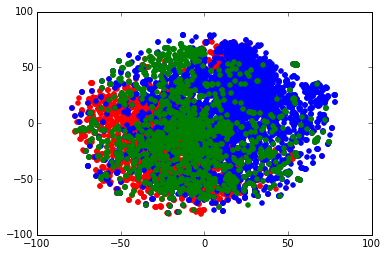

In [64]:
plt.scatter(news_tsne[:,0], news_tsne[:,1], color='red', label='news')
plt.scatter(tweet_tsne[:,0], tweet_tsne[:,1], color='blue', label='tweets')
plt.scatter(review_tsne[:,0], review_tsne[:,1], color='green', label='amazon reviews')
#plt.scatter(movie_tsne[:,0], movie_tsne[:,1], color='purple', label='movie reviews')

## Scratch, classification stuff

In [ ]:
upper_airbnb = []
with open("upper_income_airbnb.txt", "r") as f:  
    for line in f:
        if 'https' not in line[:5]:
            upper_airbnb.append(line.replace('\\\n', ' ').replace('\\n', ' ').replace('\n', ' '))
            
lower_airbnb = []
with open("lower_income_airbnb.txt", "r") as f:  
    for line in f:
        if 'https' not in line[:5]:
            lower_airbnb.append(line.replace('\\\n', ' ').replace('\\n', ' ').replace('\n', ' '))
            
upper_airbnb = pd.Series(upper_airbnb)
lower_airbnb = pd.Series(lower_airbnb)

In [4]:
clean_lower_airbnb = clean_txt(lower_airbnb)
clean_upper_airbnb = clean_txt(upper_airbnb)

In [48]:
q1_tweets = pd.read_csv('q1_tweets.csv')
q4_tweets = pd.read_csv('q4_tweets.csv')
clean_q1 = clean_tweets(q1_tweets)['text']
clean_q4 = clean_tweets(q4_tweets)['text']

In [54]:
q1_data = clean_q1
q4_data = clean_q4

In [398]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [26]:
def randomize(arrays, size=None):
    if not size: 
        size = arrays[0].shape[0]

    # Generate the permutation index array.
    np.random.seed(0)
    permutation = np.random.permutation(size)
    return [a[permutation] for a in arrays]

In [58]:
all_clean = np.concatenate((q1_data, q4_data), axis=0)
n_q1 = len(q1_data)
n_q4 = len(q4_data)
y = np.concatenate((np.zeros(n_q1),np.ones(n_q4))) 
all_clean, y = randomize([all_clean, y])
vectorizer = CountVectorizer(min_df=5, max_df=0.95, stop_words='english')
X = vectorizer.fit_transform(all_clean) 
print(X.toarray())
print(vectorizer.get_feature_names())

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[u'aa', u'aaliyah', u'aaron', u'aawww', u'ab', u'abandon', u'abandoned', u'abc', u'abdc', u'abiding', u'ability', u'able', u'abortion', u'abs', u'absolute', u'absolutely', u'absurd', u'abt', u'abuse', u'abused', u'abusive', u'abyss', u'ac', u'academy', u'acc', u'accent', u'accept', u'acceptable', u'accepted', u'accepting', u'access', u'accessdenied', u'accident', u'accidentally', u'accomplish', u'accomplished', u'according', u'account', u'accounting', u'accounts', u'acct', u'accused', u'ace', u'aced', u'ache', u'ack', u'acknowledge', u'acne', u'acres', u'act', u'actin', u'acting', u'action', u'actions', u'active', u'activity', u'actn', u'actor', u'actors', u'actress', u'acts', u'actual', u'actually', u'ad', u'adam', u'adams', u'add', u'added', u'addict', u'addicted', u'addiction', u'addictive', u'adding', u'addition', u'address', u'adidas', u'adios', u'adjust'

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=0, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.125, random_state=0, stratify=y_train)

In [60]:
lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
Cs = [1.0/l for l in lambdas]

val_scores = []
test_scores = []
for i in range(len(Cs)):
    lr = LogisticRegression(C=Cs[i])
    lr.fit(X_train, y_train)
    val_scores.append(lr.score(X_val, y_val))
    test_scores.append(lr.score(X_test, y_test))

best_C_idx = np.argmax(val_scores)
best_C = Cs[best_C_idx]
print lambdas[best_C_idx]
print test_scores[best_C_idx]

0.001
0.588021778584


In [61]:
lr = LogisticRegression(C=best_C)
lr.fit(X_train, y_train)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [62]:
feats = lr.coef_[0].argsort()[:50][::-1]
print lr.coef_[0][feats]
np.flip(np.array(vectorizer.get_feature_names())[feats],0)

[-1.4162031  -1.42961062 -1.43297456 -1.44233025 -1.4479053  -1.46283221
 -1.47394711 -1.47426913 -1.48923811 -1.49236071 -1.51447565 -1.51724571
 -1.51981003 -1.53230638 -1.53769931 -1.54766205 -1.55224397 -1.55267494
 -1.5677821  -1.59097676 -1.59163757 -1.59625257 -1.60922922 -1.62004494
 -1.62572532 -1.6371718  -1.64274988 -1.66886697 -1.67342582 -1.69547772
 -1.69866947 -1.70655222 -1.73058802 -1.73401128 -1.75351267 -1.75667815
 -1.78732193 -1.78885984 -1.80939976 -1.83012631 -1.85282502 -1.87608494
 -1.89276939 -1.92610925 -2.15589915 -2.18413817 -2.18647482 -2.28914233
 -3.02077368 -3.02400692]


array([u'sell', u'inside', u'lucky', u'line', u'mail', u'coffee', u'sus',
       u'office', u'liking', u'brand', u'craving', u'letter', u'asking',
       u'body', u'sun', u'ended', u'feels', u'ooo', u'jeezy', u'ahhh',
       u'enjoy', u'stopped', u'kidding', u'eh', u'absolutely', u'ran',
       u'needed', u'celebrities', u'trey', u'fan', u'sed', u'sad', u'juss',
       u'moves', u'yeh', u'breath', u'asked', u'police', u'oooo',
       u'formspring', u'wife', u'sup', u'mewithoutyouislike', u'sitting',
       u'fyi', u'lmfaoo', u'added', u'older', u'ms', u'clap'],
      dtype='<U26')

In [63]:
feats = lr.coef_[0].argsort()[-50:][::-1]
print lr.coef_[0][feats]
np.array(vectorizer.get_feature_names())[feats]

[ 2.58489789  2.41290628  2.26351107  2.13166528  1.97037186  1.95796663
  1.95108806  1.93247758  1.89973186  1.88627374  1.81848531  1.81500664
  1.7650461   1.75908759  1.74837077  1.73235687  1.69809362  1.68504489
  1.6797702   1.67760573  1.67453301  1.6707484   1.66721812  1.6403072
  1.61616009  1.60627324  1.60589805  1.60042605  1.58863383  1.58536105
  1.56717818  1.56659599  1.56082404  1.5288923   1.51450679  1.50229338
  1.49776116  1.49611162  1.49564697  1.47107475  1.46604155  1.46293105
  1.46191693  1.45472653  1.45222423  1.44720541  1.44275806  1.42963389
  1.42697165  1.42663472]


array([u'knows', u'naw', u'dream', u'cum', u'building', u'jk', u'fee',
       u'bus', u'student', u'grandma', u'blk', u'campus', u'hittin',
       u'gimme', u'famu', u'lawd', u'od', u'ny', u'mane', u'thend',
       u'miami', u'mood', u'tape', u'atam', u'yuck', u'mf',
       u'realgrandmas', u'ish', u'cleveland', u'fake', u'hangover',
       u'ihop', u'whatchu', u'ignored', u'sister', u'literally', u'dogs',
       u'break', u'young', u'fckin', u'rite', u'floor', u'drama', u'tu',
       u'daughter', u'live', u'makes', u'streets', u'round', u'running'],
      dtype='<U26')

In [67]:
q1 = vectorizer.transform(q1_data).toarray()
q4 = vectorizer.transform(q4_data).toarray()

In [68]:
max_indices = q1.sum(axis=0).argsort()[-50:][::-1]

In [69]:
np.array(vectorizer.get_feature_names())[max_indices]

array([u'lol', u'like', u'lt', u'just', u'got', u'good', u'don', u'lmao',
       u'love', u'shit', u'know', u'ur', u'need', u'im', u'time', u'ya',
       u'right', u'smh', u'day', u'think', u'ass', u'oh', u'gt', u'wit',
       u'haha', u'da', u'want', u'man', u'ff', u'did', u'damn', u'ok',
       u'really', u'let', u'bout', u'new', u'work', u'say', u'going',
       u'make', u'gonna', u'wanna', u'today', u'aint', u'nigga', u'll',
       u'yea', u'come', u'feel', u'people'],
      dtype='<U26')

In [70]:
max_indices = q4.sum(axis=0).argsort()[-50:][::-1]
np.array(vectorizer.get_feature_names())[max_indices]

array([u'lol', u'like', u'lt', u'just', u'got', u'lmao', u'good', u'don',
       u'shit', u'know', u'love', u'im', u'smh', u'ur', u'need', u'da',
       u'ya', u'wit', u'time', u'ass', u'right', u'gt', u'think', u'damn',
       u'day', u'ok', u'bout', u'man', u'nigga', u'aint', u'want', u'yea',
       u'fuck', u'say', u'wanna', u'oh', u'did', u'really', u'ff', u'yall',
       u'let', u'new', u'going', u'come', u'make', u'yo', u'wat', u'work',
       u'twitter', u'dat'],
      dtype='<U26')

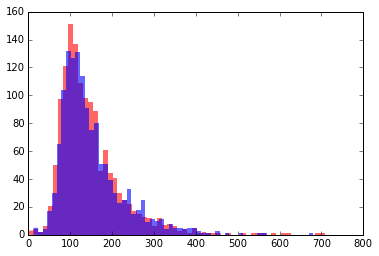

In [71]:
import matplotlib.pyplot as plt
% matplotlib inline 

plt.hist(np.count_nonzero(q1, axis=1), bins=60, color='red', linewidth=0, alpha=0.6);
plt.hist(np.count_nonzero(q4, axis=1), bins=60, color='blue', linewidth=0, alpha=0.6);

In [72]:
n_q1, n_q4

(1377, 1377)

In [103]:
import math
from textblob import TextBlob as tb
from __future__ import division, unicode_literals    

In [104]:
def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

In [31]:
all_tweets = ' '.join([t for t in cleaned_tweets])
all_movies = ' '.join([t for t in clean_movie_reviews])
all_amazon = ' '.join([t for t in clean_reviews])
all_news = ' '.join([t for t in clean_news])


In [33]:
bloblist = [tb(doc) for doc in [all_tweets, all_movies, all_amazon, all_news]]
all_scores = dict()
counts = dict()
for i, blob in enumerate(bloblist):
    print("Top words in document {}".format(i + 1))
    for word in blob.words: 
        if word in all_scores: 
            counts[word] += 1
            all_scores[word] += tfidf(word, blob, bloblist) 
        else: 
            counts[word] = 1
            all_scores[word] = tfidf(word, blob, bloblist) 
            
#     scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
#     sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
#     for word, score in sorted_words[:3]:
#         print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

Top words in document 1


KeyboardInterrupt: 

In [29]:
for word in all_scores.keys(): 
    all_scores[word] = all_scores[word]*1.0/counts[word]
sorted_words = sorted(all_scores.items(), key=lambda x: x[1], reverse=True)
for word, score in sorted_words[:10]:
    print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

	Word: coff, TF-IDF: 1.25182
	Word: forg, TF-IDF: 0.45521
	Word: decoration, TF-IDF: 0.45521
	Word: refined, TF-IDF: 0.45521
	Word: pacoima, TF-IDF: 0.38518
	Word: amusing, TF-IDF: 0.38518
	Word: hospitable, TF-IDF: 0.38518
	Word: wif, TF-IDF: 0.31296
	Word: hideout, TF-IDF: 0.26354
	Word: fra, TF-IDF: 0.25036
